In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/home/ubuntu/.virtualenvs/catacq/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/ubuntu/.virtualenvs/catacq/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import sys
sys.path.append('..')

# Initialization
## Hyperparameters for discovery

In [3]:
adsorbate = 'OH'
target_energy = 1.23  # eV
# total_size_limit = 600
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [4]:
%%cache example_data.pkl training_features, training_labels, training_surfaces, sampling_features, sampling_labels, sampling_surfaces

import random
import numpy as np
from gaspy.gasdb import get_adsorption_docs, get_surface_from_doc


docs = get_adsorption_docs(adsorbate)
# docs = random.sample(docs, total_size_limit)
random.shuffle(docs)


def parse_docs(docs):
    '''
    Our testing framework needs us to divide information into features, labels, and surfaces.
    This function will convert a list of docs/dictionaries into these things.
    
    Arg:
        docs    A list of dictionaries from `gaspy.gasdb.get_adsorption_docs`
    Returns:
        features    ...just the `docs` arg
        labels      A list of the 'energy' keys in `docs`
        surfaces    A list of 4-tuples indicating the surfaces of `docs
    '''
    features = docs
    labels = [doc['energy'] for doc in docs]
    surfaces = [get_surface_from_doc(doc) for doc in docs]
    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_docs(docs[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_docs(docs[initial_training_size:])

[Skipped the cell's code and loaded variables sampling_features, sampling_labels, sampling_surfaces, training_features, training_labels, training_surfaces from file '/home/ubuntu/proj/catalyst-acquisitions/notebooks/example_data.pkl'.]
successfully loaded your custom FW_config.yaml!
Now pulling adsorption documents...


4077it [00:00, 45544.97it/s]


In [5]:
# Load and parse fingerprints

import pickle
import numpy as np

pick_dict = pickle.load(open('fingerprints.pkl', 'rb'))
training_fingerprints = pick_dict['training_fingerprints']
training_labels = pick_dict['training_labels']
training_surfaces = pick_dict['training_surfaces']
sampling_fingerprints = pick_dict['sampling_fingerprints']
sampling_labels = pick_dict['sampling_labels']
sampling_surfaces = pick_dict['sampling_surfaces']

training_combined = np.array([np.r_[fe['shift'], fi] for fe, fi in zip(training_features, training_fingerprints)])
sampling_combined = np.array([np.r_[fe['shift'], fi] for fe, fi in zip(sampling_features, sampling_fingerprints)])

# Hallucinate
## Initialize

In [6]:
from src.discoverers.adsorption.bo import BayesianOptimizer

# Initialize
discoverer = BayesianOptimizer(target_energy=target_energy,
                               quantile_cutoff=quantile_cutoff,
                               batch_size=batch_size,
                               training_features=training_combined,
                               training_labels=training_labels,
                               training_surfaces=training_surfaces,
                               sampling_features=sampling_combined,
                               sampling_labels=sampling_labels,
                               sampling_surfaces=sampling_surfaces,
                               init_train=True  # Set to `False` only for warm starts
                              )

## Run

In [7]:
discoverer.simulate_discovery()

In [8]:
# Or load the last run
# discoverer.load_last_run()

## Analyze

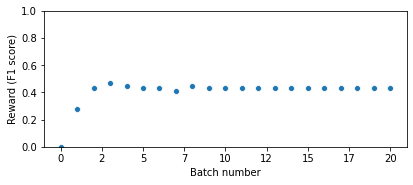

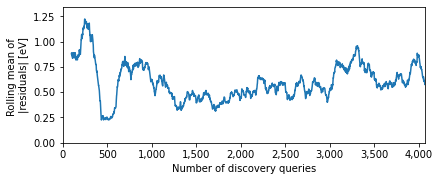

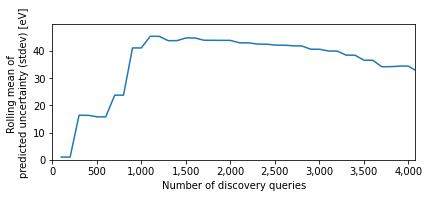

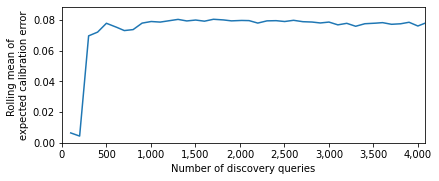

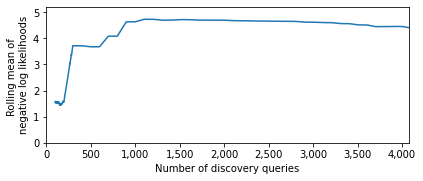

In [9]:
reward_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)